In [58]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.metrics import mean_squared_error,r2_score
SEED=42

In [2]:
path=r"C:\Users\JAYADEVA JAVALI\Desktop\cs\diamonds.csv"
df = pd.read_csv(path)
df.head()

,Unnamed: 0,carat,cut,color,clarity,depth,table,price,x,y,z
0,1,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,2,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,3,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,4,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,5,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


* **carat** - Carat weight of the diamond.
* **cut** - Describes the cut quality of the diamond (from the best to worst: Ideal, Premium, Very Good, Good and Fair).
* **color** - Color of the diamond (from the best to worst: D, E, F, G, H, I and J).
* **clarity** - A measurement of how clear the diamond is (from the best to worst: IF, VVS1, VVS2, VS1, VS2, SI1, SI2 and I1).
* **depth** - The height of a diamond, measured from the culet to the table, divided by the average girdle diameter (%).
* **table** - The width of a diamond table expressed as a percentage of the average diameter (%).
* **x** - Diamond length (mm).
* **y** - Diamond width (mm).
* **z** - Diamond depth (mm).
* **price** - Diamond price. 

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53940 entries, 0 to 53939
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  53940 non-null  int64  
 1   carat       53940 non-null  float64
 2   cut         53940 non-null  object 
 3   color       53940 non-null  object 
 4   clarity     53940 non-null  object 
 5   depth       53940 non-null  float64
 6   table       53940 non-null  float64
 7   price       53940 non-null  int64  
 8   x           53940 non-null  float64
 9   y           53940 non-null  float64
 10  z           53940 non-null  float64
dtypes: float64(6), int64(2), object(3)
memory usage: 4.5+ MB


In [4]:
df.shape

(53940, 11)

### Missing Values

In [5]:
df.isnull().sum()

Unnamed: 0    0
carat         0
cut           0
color         0
clarity       0
depth         0
table         0
price         0
x             0
y             0
z             0
dtype: int64

In [6]:
if df.isnull().sum().any() == False:
    print("There are no missing values")
else:
    print("There are missing values")

There are no missing values


### Checking for duplicate rows and removing unnecessary columns  

In [7]:
# Dropping "Unnamed: 0" column
df = df.drop(["Unnamed: 0"], axis = 1)

In [8]:
# Checking for duplicate rows
print("number of duplicate rows: ", df.duplicated().sum())

number of duplicate rows:  146


In [9]:
df.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


### High Level Information 

In [10]:
df.describe().T
#df.describe()
#Numerical Data

,count,mean,std,min,25%,50%,75%,max
carat,53940.0,0.797940,0.474011,0.2,0.40,0.70,1.04,5.01
depth,53940.0,61.749405,1.432621,43.0,61.00,61.80,62.50,79.00
table,53940.0,57.457184,2.234491,43.0,56.00,57.00,59.00,95.00
price,53940.0,3932.799722,3989.439738,326.0,950.00,2401.00,5324.25,18823.00
x,53940.0,5.731157,1.121761,0.0,4.71,5.70,6.54,10.74
y,53940.0,5.734526,1.142135,0.0,4.72,5.71,6.54,58.90
z,53940.0,3.538734,0.705699,0.0,2.91,3.53,4.04,31.80


In [11]:
# Categorical data
df.describe(include = "O").T

,count,unique,top,freq
cut,53940,5,Ideal,21551
color,53940,7,G,11292
clarity,53940,8,SI1,13065


In [12]:
format_dict = {"carat" : "{:.2f}", "depth" : "{:.1f}", "table" : "{:.1f}", "x" : "{:.2f}", "y" : "{:.2f}", "z" : "{:.2f}"}

In [13]:
df_zero = df.loc[(df["x"] == 0) | (df["y"] == 0) | (df["z"] == 0)]
df_zero.style.apply(lambda x: ["background: yellow" if n == 0 else "" for n in x], axis = 1).format(format_dict)

,carat,cut,color,clarity,depth,table,price,x,y,z
2207,1.00,Premium,G,SI2,59.1,59.0,3142,6.55,6.48,0.00
2314,1.01,Premium,H,I1,58.1,59.0,3167,6.66,6.60,0.00
4791,1.10,Premium,G,SI2,63.0,59.0,3696,6.50,6.47,0.00
5471,1.01,Premium,F,SI2,59.2,58.0,3837,6.50,6.47,0.00
10167,1.50,Good,G,I1,64.0,61.0,4731,7.15,7.04,0.00
11182,1.07,Ideal,F,SI2,61.6,56.0,4954,0.00,6.62,0.00
11963,1.00,Very Good,H,VS2,63.3,53.0,5139,0.00,0.00,0.00
13601,1.15,Ideal,G,VS2,59.2,56.0,5564,6.88,6.83,0.00
15951,1.14,Fair,G,VS1,57.5,67.0,6381,0.00,0.00,0.00
24394,2.18,Premium,H,SI2,59.4,61.0,12631,8.49,8.45,0.00


### We know that length,width and depth cannot be 0,therefore the data is wrong,lets treat these values

In [14]:
# Transforming them into NaN values
df.loc[df["x"] == 0, "x"] = np.nan 
df.loc[df["y"] == 0, "y"] = np.nan 
df.loc[df["z"] == 0, "z"] = np.nan 

In [15]:
# Seeing the number of the new missing values
df[["x", "y", "z"]].isnull().sum()

x     8
y     7
z    20
dtype: int64

### After Transformation we see the count of missing values,now lets treat the missing values.

### Checking Correlations

In [16]:
df.corr().T

,carat,depth,table,price,x,y,z
carat,1.000000,0.028224,0.181618,0.921591,0.977765,0.953989,0.961048
depth,0.028224,1.000000,-0.295779,-0.010647,-0.025097,-0.029142,0.095023
table,0.181618,-0.295779,1.000000,0.127134,0.196130,0.184519,0.152483
price,0.921591,-0.010647,0.127134,1.000000,0.887227,0.867870,0.868206
x,0.977765,-0.025097,0.196130,0.887227,1.000000,0.974933,0.975435
y,0.953989,-0.029142,0.184519,0.867870,0.974933,1.000000,0.956744
z,0.961048,0.095023,0.152483,0.868206,0.975435,0.956744,1.000000


<AxesSubplot:>

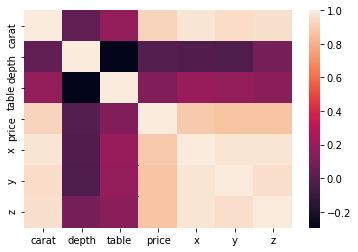

In [17]:
sns.heatmap(df.corr())

In [18]:
def get_corr(col):
    return df.corr().unstack()[col].sort_values(ascending = False)    

In [19]:
print("x correlations\n\n{0}\n\n{3}\n\ny correlations\n\n{1}\n\n{3}\n\nz correlations\n\n{2}".format(get_corr("x"), get_corr("y"), get_corr("z"), 25*"-"))

x correlations

x        1.000000
carat    0.977765
z        0.975435
y        0.974933
price    0.887227
table    0.196130
depth   -0.025097
dtype: float64

-------------------------

y correlations

y        1.000000
x        0.974933
z        0.956744
carat    0.953989
price    0.867870
table    0.184519
depth   -0.029142
dtype: float64

-------------------------

z correlations

z        1.000000
x        0.975435
carat    0.961048
y        0.956744
price    0.868206
table    0.152483
depth    0.095023
dtype: float64


## Imputing Missing Values
 x,y,z has values of 0 

In [20]:
def missing_values_imputation(col):
    carat = df.groupby(["carat"])[col].median()
    index_list = list(df.loc[df[col].isnull() == True].sort_values(by = "carat", ascending = False).index)
    for i in index_list:
        carat_value = df.loc[i, "carat"]
        new_value = carat[carat_value]
        df.loc[i, col] = new_value
        print("carat: {0} / median {1} value: {2}".format(carat_value, col, new_value))
    return df.iloc[index_list].style.applymap(lambda x: "background-color: limegreen", subset = col).format(format_dict)

In [21]:
missing_values_imputation("x")

carat: 2.25 / median x value: 8.47
carat: 1.56 / median x value: 7.46
carat: 1.2 / median x value: 6.78
carat: 1.14 / median x value: 6.71
carat: 1.07 / median x value: 6.57
carat: 1.0 / median x value: 6.38
carat: 0.71 / median x value: 5.72
carat: 0.71 / median x value: 5.72


,carat,cut,color,clarity,depth,table,price,x,y,z
27429,2.25,Premium,H,SI2,62.8,59.0,18034,8.47,nan,nan
24520,1.56,Ideal,G,VS2,62.2,54.0,12800,7.46,nan,nan
26243,1.20,Premium,D,VVS1,62.1,59.0,15686,6.78,nan,nan
15951,1.14,Fair,G,VS1,57.5,67.0,6381,6.71,nan,nan
11182,1.07,Ideal,F,SI2,61.6,56.0,4954,6.57,6.62,nan
11963,1.00,Very Good,H,VS2,63.3,53.0,5139,6.38,nan,nan
49556,0.71,Good,F,SI2,64.1,60.0,2130,5.72,nan,nan
49557,0.71,Good,F,SI2,64.1,60.0,2130,5.72,nan,nan


In [22]:
missing_values_imputation("y")

carat: 2.25 / median y value: 8.39
carat: 1.56 / median y value: 7.46
carat: 1.2 / median y value: 6.79
carat: 1.14 / median y value: 6.72
carat: 1.0 / median y value: 6.38
carat: 0.71 / median y value: 5.73
carat: 0.71 / median y value: 5.73


,carat,cut,color,clarity,depth,table,price,x,y,z
27429,2.25,Premium,H,SI2,62.8,59.0,18034,8.47,8.39,nan
24520,1.56,Ideal,G,VS2,62.2,54.0,12800,7.46,7.46,nan
26243,1.20,Premium,D,VVS1,62.1,59.0,15686,6.78,6.79,nan
15951,1.14,Fair,G,VS1,57.5,67.0,6381,6.71,6.72,nan
11963,1.00,Very Good,H,VS2,63.3,53.0,5139,6.38,6.38,nan
49556,0.71,Good,F,SI2,64.1,60.0,2130,5.72,5.73,nan
49557,0.71,Good,F,SI2,64.1,60.0,2130,5.72,5.73,nan


In [23]:
missing_values_imputation("z")

carat: 2.8 / median z value: 5.5
carat: 2.25 / median z value: 5.19
carat: 2.25 / median z value: 5.19
carat: 2.2 / median z value: 5.17
carat: 2.18 / median z value: 5.16
carat: 2.02 / median z value: 5.0
carat: 1.56 / median z value: 4.59
carat: 1.5 / median z value: 4.53
carat: 1.2 / median z value: 4.21
carat: 1.15 / median z value: 4.16
carat: 1.14 / median z value: 4.14
carat: 1.12 / median z value: 4.11
carat: 1.1 / median z value: 4.09
carat: 1.07 / median z value: 4.05
carat: 1.01 / median z value: 3.98
carat: 1.01 / median z value: 3.98
carat: 1.0 / median z value: 3.96
carat: 1.0 / median z value: 3.96
carat: 0.71 / median z value: 3.54
carat: 0.71 / median z value: 3.54


,carat,cut,color,clarity,depth,table,price,x,y,z
27739,2.80,Good,G,SI2,63.8,58.0,18788,8.90,8.85,5.50
26123,2.25,Premium,I,SI1,61.3,58.0,15397,8.52,8.42,5.19
27429,2.25,Premium,H,SI2,62.8,59.0,18034,8.47,8.39,5.19
27112,2.20,Premium,H,SI1,61.2,59.0,17265,8.42,8.37,5.17
24394,2.18,Premium,H,SI2,59.4,61.0,12631,8.49,8.45,5.16
27503,2.02,Premium,H,VS2,62.7,53.0,18207,8.02,7.95,5.00
24520,1.56,Ideal,G,VS2,62.2,54.0,12800,7.46,7.46,4.59
10167,1.50,Good,G,I1,64.0,61.0,4731,7.15,7.04,4.53
26243,1.20,Premium,D,VVS1,62.1,59.0,15686,6.78,6.79,4.21
13601,1.15,Ideal,G,VS2,59.2,56.0,5564,6.88,6.83,4.16


E:\anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


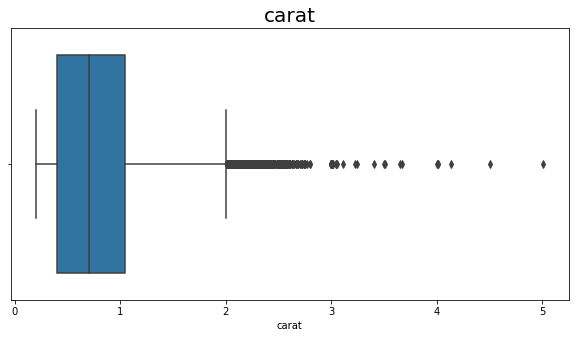

E:\anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


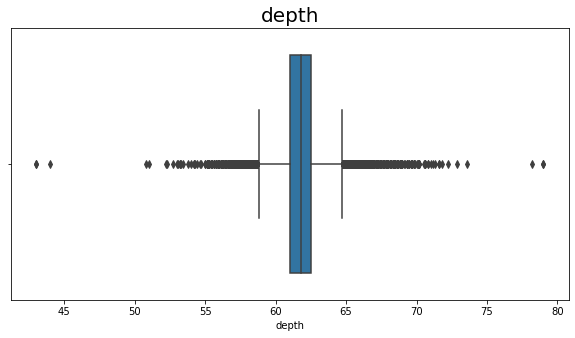

E:\anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


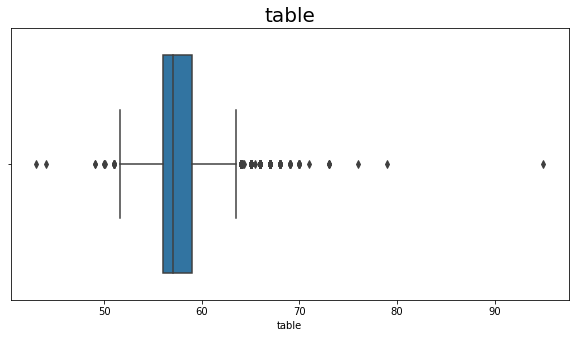

E:\anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


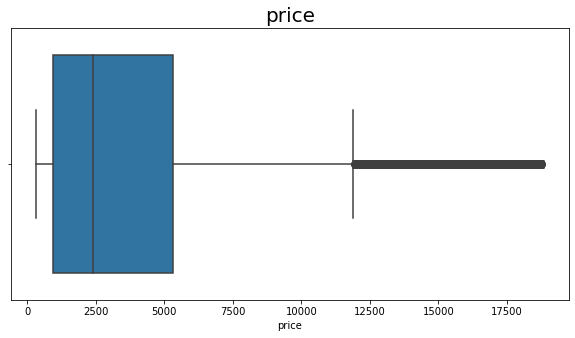

E:\anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


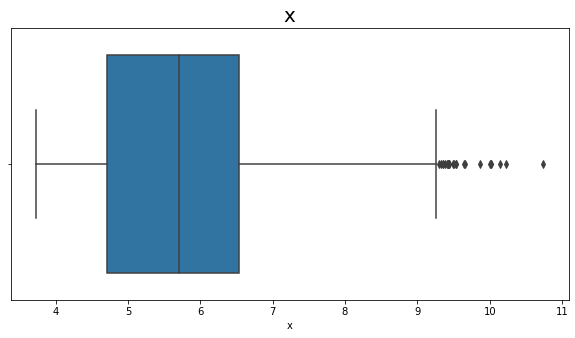

E:\anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


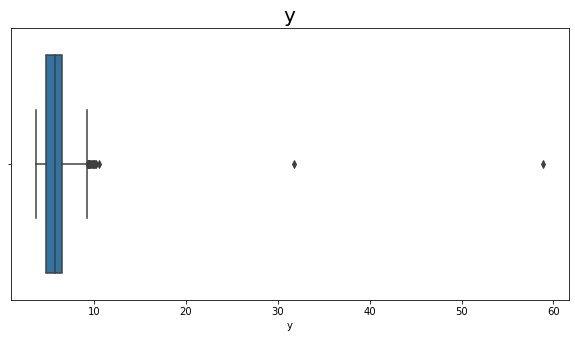

E:\anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


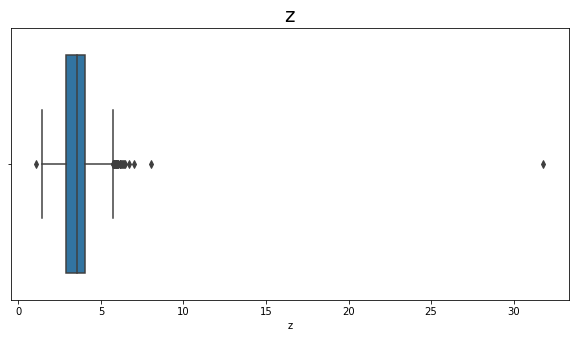

In [24]:
for c in ['carat', 'depth', 'table', 'price', 'x', 'y', 'z']:
    plt.figure(figsize=(10, 5))
    sns.boxplot(df[c])
    plt.title(c, fontsize=20)
    plt.show()

### Plotting Regression Fit with respect to target variable to visualize and find outliers 

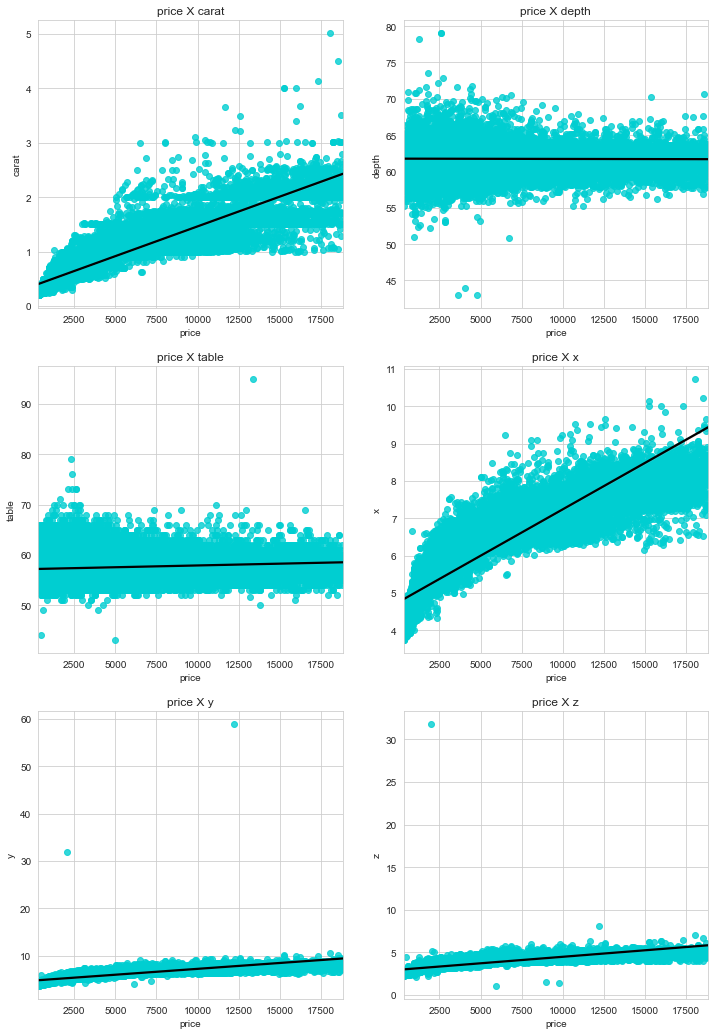

In [25]:
sns.set_style("whitegrid")
c = "darkturquoise"
#c = "lightsalmon"
#c = "crimson"

plt.figure(figsize = (12, 18))
plt.subplot(3, 2, 1)
plt.title("price X carat")
sns.regplot(data = df, x = "price", y = "carat", color = c, line_kws = {"color" : "black"})
plt.subplot(3, 2, 2)
plt.title("price X depth")
sns.regplot(data = df, x = "price", y = "depth", color = c, line_kws = {"color" : "black"})
plt.subplot(3, 2, 3)
plt.title("price X table")
sns.regplot(data = df, x = "price", y = "table", color = c, line_kws = {"color" : "black"})
plt.subplot(3, 2, 4)
plt.title("price X x")
sns.regplot(data = df, x = "price", y = "x", color = c, line_kws = {"color" : "black"})
plt.subplot(3, 2, 5)
plt.title("price X y")
sns.regplot(data = df, x = "price", y = "y", color = c, line_kws = {"color" : "black"})
plt.subplot(3, 2, 6)
plt.title("price X z")
sns.regplot(data = df, x = "price", y = "z", color = c, line_kws = {"color" : "black"})
plt.show()

From the above interpretation we see that Outliers exist in 
* **Price vs y**
* **Price vs z**

In [26]:
def highlight_outliers(outliers, col):
    outliers_index = outliers.index
    i = pd.IndexSlice[outliers_index, col]
    return outliers.style.applymap(lambda x: "background-color: red", subset = i).format(format_dict)

* **Price vs y** 

In [27]:
df_outliers = df.loc[df["y"] > 30].copy()
highlight_outliers(df_outliers, "y")

,carat,cut,color,clarity,depth,table,price,x,y,z
24067,2.00,Premium,H,SI2,58.9,57.0,12210,8.09,58.90,8.06
49189,0.51,Ideal,E,VS1,61.8,55.0,2075,5.15,31.80,5.12


* **Price vs z** 

In [28]:
df_outliers = df.loc[df["z"] > 30].copy()
highlight_outliers(df_outliers, "z")

,carat,cut,color,clarity,depth,table,price,x,y,z
48410,0.51,Very Good,E,VS1,61.8,54.7,1970,5.12,5.15,31.80


In [29]:
# Transforming them into NaN values
df.loc[df["y"] > 30, "y"] = np.nan
df.loc[df["z"] > 30, "z"] = np.nan

### Let us impute these outliers

In [30]:
missing_values_imputation("y")

carat: 2.0 / median y value: 8.01
carat: 0.51 / median y value: 5.14


,carat,cut,color,clarity,depth,table,price,x,y,z
24067,2.00,Premium,H,SI2,58.9,57.0,12210,8.09,8.01,8.06
49189,0.51,Ideal,E,VS1,61.8,55.0,2075,5.15,5.14,5.12


In [31]:
missing_values_imputation("z")

carat: 0.51 / median z value: 3.17


,carat,cut,color,clarity,depth,table,price,x,y,z
48410,0.51,Very Good,E,VS1,61.8,54.7,1970,5.12,5.15,3.17


### Checking for other outliers

* **price vs depth**

In [32]:
df_outliers = df.loc[(df["depth"] > 75) | (df["depth"] < 45)].copy()
highlight_outliers(df_outliers, "depth")

,carat,cut,color,clarity,depth,table,price,x,y,z
4518,1.00,Fair,G,SI1,43.0,59.0,3634,6.32,6.27,3.97
6341,1.00,Fair,G,VS2,44.0,53.0,4032,6.31,6.24,4.12
10377,1.09,Ideal,J,VS2,43.0,54.0,4778,6.53,6.55,4.12
41918,1.03,Fair,E,I1,78.2,54.0,1262,5.72,5.59,4.42
52860,0.50,Fair,E,VS2,79.0,73.0,2579,5.21,5.18,4.09
52861,0.50,Fair,E,VS2,79.0,73.0,2579,5.21,5.18,4.09


They are not absurd values ,so let us not impute them and keep actual values for analysis

* **price vs table**

In [33]:
df_outliers = df.loc[(df["table"] > 90) | (df["table"] < 45)].copy()
highlight_outliers(df_outliers, "table")

,carat,cut,color,clarity,depth,table,price,x,y,z
11368,1.04,Ideal,I,VS1,62.9,43.0,4997,6.45,6.41,4.04
24932,2.01,Fair,F,SI1,58.6,95.0,13387,8.32,8.31,4.87
35633,0.29,Very Good,E,VS1,62.8,44.0,474,4.20,4.24,2.65


We see it to be similar with depth,therefore let's keep it actual. 

* **Price vs z** 

In [34]:
df_outliers = df.loc[df["z"] < 2].copy()
highlight_outliers(df_outliers, "z")

,carat,cut,color,clarity,depth,table,price,x,y,z
14635,1.07,Ideal,F,SI1,60.6,57.0,5909,6.62,6.67,1.07
20694,1.53,Ideal,I,SI1,61.9,54.0,8971,7.43,7.50,1.53
21654,1.41,Ideal,H,VS1,60.7,56.0,9752,7.31,7.22,1.41


We see that there are few values same as carat,which is not right,so let us impute them

In [36]:
df.loc[df["carat"] == df["z"], ["carat", "z"]]

,carat,z
14635,1.07,1.07
20694,1.53,1.53
21654,1.41,1.41


In [37]:
# Transforming them into NaN values
df.loc[df["z"] < 2, "z"] = np.nan

In [38]:
missing_values_imputation("z")

carat: 1.53 / median z value: 4.56
carat: 1.41 / median z value: 4.44
carat: 1.07 / median z value: 4.05


,carat,cut,color,clarity,depth,table,price,x,y,z
20694,1.53,Ideal,I,SI1,61.9,54.0,8971,7.43,7.50,4.56
21654,1.41,Ideal,H,VS1,60.7,56.0,9752,7.31,7.22,4.44
14635,1.07,Ideal,F,SI1,60.6,57.0,5909,6.62,6.67,4.05


### Data Visualization

### Bar Plot between cut and price

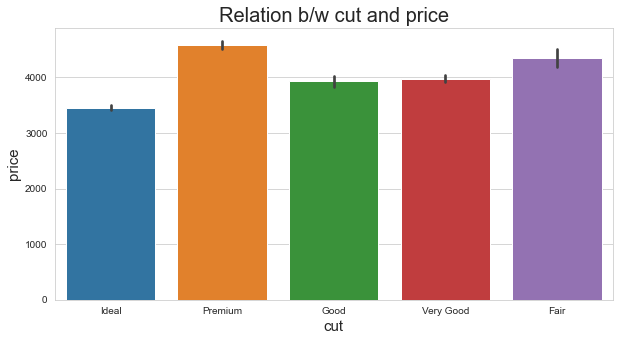

In [39]:
plt.figure(figsize=(10, 5))
sns.barplot(x='cut', y='price', data=df)
plt.title('Relation b/w cut and price', fontsize=20);
plt.xlabel('cut', fontsize=15)
plt.ylabel('price', fontsize=15);

In [40]:
df.corr()['price'].sort_values(ascending=False)[1:]

carat    0.921591
y        0.888800
x        0.887206
z        0.882368
table    0.127134
depth   -0.010647
Name: price, dtype: float64

E:\anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


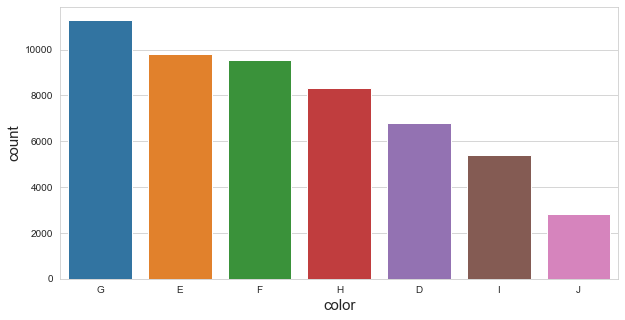

In [41]:
''' color category '''
color_label = df.color.value_counts()
plt.figure(figsize=(10, 5))
sns.barplot(color_label.index, color_label);
plt.ylabel('count', fontsize=15)
plt.xlabel('color', fontsize=15);

### Bar Plot between clarity and price

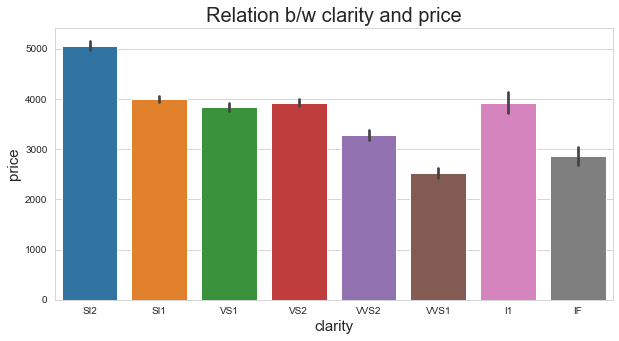

In [42]:
plt.figure(figsize=(10, 5))
sns.barplot(x='clarity', y='price', data=df);
plt.title('Relation b/w clarity and price', fontsize=20)
plt.xlabel('clarity', fontsize=15)
plt.ylabel('price', fontsize=15);

In [44]:
cut_palette = ["darkturquoise", "lightskyblue", "paleturquoise", "lightcyan", "azure"]
color_palette = ["cadetblue", "deepskyblue", "darkturquoise", "lightskyblue", "paleturquoise", "lightcyan", "azure"]
clarity_palette = ["cadetblue", "deepskyblue", "darkturquoise", "lightskyblue", "paleturquoise", "lightcyan", "azure", "ghostwhite"]

df["cut"] = pd.Categorical(df["cut"], categories = ["Ideal", "Premium", "Very Good", "Good", "Fair"], ordered = True)
df["color"] = pd.Categorical(df["color"], categories = ["D", "E", "F", "G", "H", "I", "J"], ordered = True)
df["clarity"] = pd.Categorical(df["clarity"], categories = ["IF", "VVS1", "VVS2", "VS1", "VS2", "SI1", "SI2", "I1"], ordered = True)

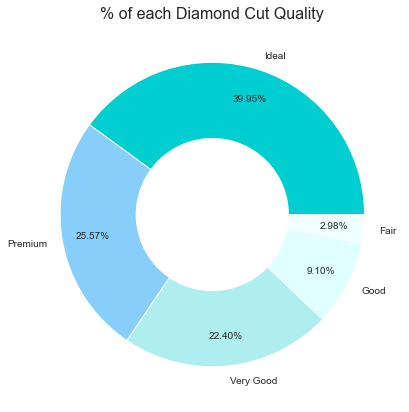

In [45]:
df_cut = df["cut"].value_counts()

plt.figure(figsize = (7,7))
plt.pie(data = df_cut, x = df_cut.values, labels = df_cut.index, autopct = "%.2f%%", pctdistance = 0.8, colors = cut_palette )
circle = plt.Circle(xy = (0, 0), radius = 0.5, facecolor = 'white')
plt.gca().add_artist(circle)
plt.title("% of each Diamond Cut Quality", size = 16)
plt.show()

Ideal>Premium>VeryGood>Good>Fair  

In [46]:
position = 0
for cut in df_cut:
    print("{0} quality cuts: {1}".format(df_cut.index[position], df_cut.values[position]))
    position += 1

Ideal quality cuts: 21551
Premium quality cuts: 13791
Very Good quality cuts: 12082
Good quality cuts: 4906
Fair quality cuts: 1610


We can come to a conclusion that there are more number of high and well cut diamonds.

**Checking cut with regards to price**

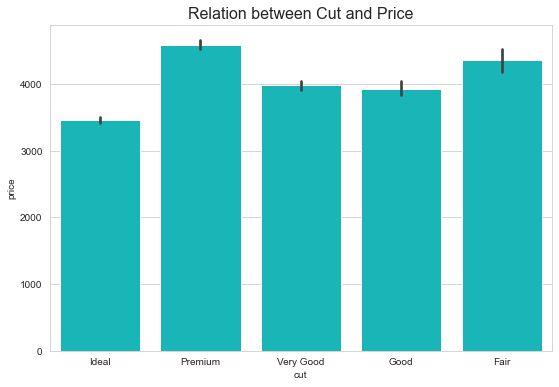

In [47]:
plt.figure(figsize = (9, 6))
sns.barplot(data = df, x = "cut", y = "price", color = c)
plt.title("Relation between Cut and Price", size = 16)
plt.show()

Here we see a unusual interpretation,let us check the correlation

In [48]:
get_corr("price")

price    1.000000
carat    0.921591
y        0.888800
x        0.887206
z        0.882368
table    0.127134
depth   -0.010647
dtype: float64

**carat is the most important thing with regards to price,diamonds with ideal cuts should have lower carat value** 

In [49]:
df.groupby(["cut"])["carat"].mean()

cut
Ideal        0.702837
Premium      0.891955
Very Good    0.806381
Good         0.849185
Fair         1.046137
Name: carat, dtype: float64

Here we see the mean of Ideal cuts is very low compared to others,therefore the affect in graph.

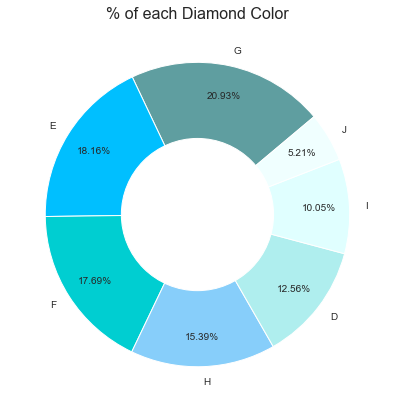

In [50]:
df_color = df["color"].value_counts()

plt.figure(figsize = (7,7))
plt.pie(data = df_color, x = df_color.values, labels = df_color.index, autopct = "%.2f%%", pctdistance = 0.8, startangle = 40, colors = color_palette)
circle = plt.Circle(xy = (0, 0), radius = 0.5, facecolor = 'white')
plt.gca().add_artist(circle)
plt.title("% of each Diamond Color", size = 16)
plt.show()

D>E>F>G>H>I>J 

In [51]:
position = 0
for color in df_color:
    print("{0} color diamonds: {1}".format(df_color.index[position], df_color.values[position]))
    position += 1

G color diamonds: 11292
E color diamonds: 9797
F color diamonds: 9542
H color diamonds: 8304
D color diamonds: 6775
I color diamonds: 5422
J color diamonds: 2808


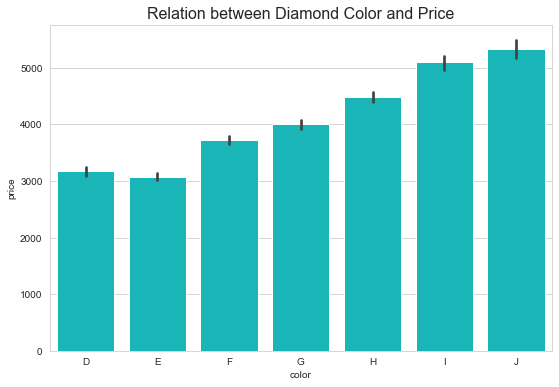

In [52]:
plt.figure(figsize = (9, 6))
sns.barplot(data = df, x = "color", y = "price", color = c)
plt.title("Relation between Diamond Color and Price", size = 16)
plt.show()

Again, the mean price of diamonds with better colors are lower than all other diamonds with worst colors. 

In [53]:
df.groupby(["color"])["carat"].mean()

color
D    0.657795
E    0.657867
F    0.736538
G    0.771190
H    0.911799
I    1.026927
J    1.162137
Name: carat, dtype: float64

We observe the same here,D has the lowest mean value

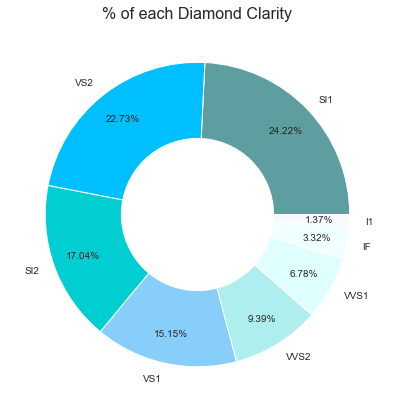

In [54]:
df_clarity = df["clarity"].value_counts()

plt.figure(figsize = (7,7))
plt.pie(data = df_clarity, x = df_clarity.values, labels = df_clarity.index, autopct = "%.2f%%", pctdistance = 0.8, colors = clarity_palette)
circle = plt.Circle(xy = (0, 0), radius = 0.5, facecolor = 'white')
plt.gca().add_artist(circle)
plt.title("% of each Diamond Clarity", size = 16)
plt.show()

IF > VVS1 > VVS2 > VS1 > VS2 > SI1 > SI2 > I1

In [55]:
position = 0
for color in df_clarity:
    print("{0} clarity diamonds: {1}".format(df_clarity.index[position], df_clarity.values[position]))
    position += 1 

SI1 clarity diamonds: 13065
VS2 clarity diamonds: 12258
SI2 clarity diamonds: 9194
VS1 clarity diamonds: 8171
VVS2 clarity diamonds: 5066
VVS1 clarity diamonds: 3655
IF clarity diamonds: 1790
I1 clarity diamonds: 741


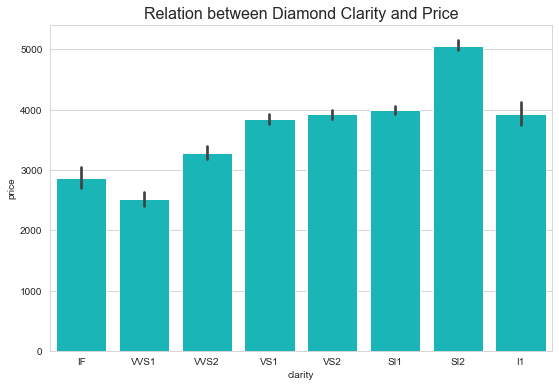

In [56]:
plt.figure(figsize = (9, 6))
sns.barplot(data = df, x = "clarity", y = "price", color = c)
plt.title("Relation between Diamond Clarity and Price", size = 16)
plt.show()

In [57]:
df.groupby(["clarity"])["carat"].mean()

clarity
IF      0.505123
VVS1    0.503321
VVS2    0.596202
VS1     0.727158
VS2     0.763935
SI1     0.850482
SI2     1.077648
I1      1.283846
Name: carat, dtype: float64

We observe the same again,VVS1 has the lowest mean.

### DATA PREPROCESSING TO IMPLEMENT VARIOUS MODELS

In [59]:
label_cut = LabelEncoder()
label_color = LabelEncoder()
label_clarity = LabelEncoder()


df['cut'] = label_cut.fit_transform(df['cut'])
df['color'] = label_color.fit_transform(df['color'])
df['clarity'] = label_clarity.fit_transform(df['clarity'])

In [60]:
df.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,2,1,3,61.5,55.0,326,3.95,3.98,2.43
1,0.21,3,1,2,59.8,61.0,326,3.89,3.84,2.31
2,0.23,1,1,4,56.9,65.0,327,4.05,4.07,2.31
3,0.29,3,5,5,62.4,58.0,334,4.20,4.23,2.63
4,0.31,1,6,3,63.3,58.0,335,4.34,4.35,2.75


In [61]:
X = df.drop(["price"], axis = 1).copy()
y = df["price"].copy()

In [62]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.1, random_state=40)

### Linear Regression

In [70]:
regressor = LinearRegression()
regressor.fit(X_train, y_train)
prediction = regressor.predict(X_test)
rmse_Lreg = np.sqrt(mean_squared_error(y_test, prediction))
print('RMSE value is = {}'.format(rmse_Lreg))
r2_Lreg = r2_score(y_test, prediction)
print('R-squared value is {}'.format(r2_Lreg))

RMSE value is = 1376.6250458046643
R-squared value is 0.8841897788553627


### Random Forest Regressor

In [71]:
RFreg_model = RandomForestRegressor()
RFreg_model.fit(X_train,y_train)
prediction2 = RFreg_model.predict(X_test)
rmse_RFreg = np.sqrt(mean_squared_error(y_test, prediction2))
print('RMSE value is = {}'.format(rmse_RFreg))
r2_RFreg = r2_score(y_test, prediction2)
print('R-squared value is {}'.format(r2_RFreg))

RMSE value is = 522.9692644787389
R-squared value is 0.9832864814086221


### Polynomial Regressor

In [72]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
poly_reg = PolynomialFeatures(degree = 4)
X_poly = poly_reg.fit_transform(X_train)
regressor = LinearRegression()
regressor.fit(X_poly, y_train)
prediction3 = regressor.predict(poly_reg.transform(X_test))

ploy_reg = np.sqrt(mean_squared_error(y_test, prediction3))
print('RMSE value is = {}'.format(ploy_reg))
r2_poly_reg = r2_score(y_test, prediction3)
print('R-squared value is {}'.format(r2_poly_reg))

RMSE value is = 977.721538221508
R-squared value is 0.9415821025119236


### Decision Tree Regressor 

In [73]:
regressor1 = DecisionTreeRegressor(random_state = 0)
regressor1.fit(X_train, y_train)
prediction4 = regressor1.predict(X_test)
dt_reg = np.sqrt(mean_squared_error(y_test, prediction4))
print('RMSE value is = {}'.format(dt_reg))
r2_dt_reg = r2_score(y_test, prediction4)
print('R-squared value is {}'.format(r2_dt_reg))

RMSE value is = 746.5701536975055
R-squared value is 0.9659390462125902


### XGB Regressor

In [82]:
xgbr = XGBRegressor(learning_rate = 0.1, n_estimators = 200, random_state = SEED)
xgbr.fit(X_train,y_train)
prediction5 = xgbr.predict(X_test)
xgbr_reg = np.sqrt(mean_squared_error(y_test, prediction5))
print('RMSE value is = {}'.format(xgbr_reg))
r2_xgbr_reg = r2_score(y_test, prediction5)
print('R-squared value is {}'.format(r2_xgbr_reg))

RMSE value is = 7878.687711787642
R-squared value is -2.7933536281218787


In [86]:
Result= pd.DataFrame({'Actual Price':y_test,'Predicted Price By LinearRegression':prediction,'Predicted Price By RandomForest':prediction2,'Predicted Price By PolynomialRegressor':prediction3,'Predicted Price By DecisionTreeRegressor':prediction4,'Predicted Price By XgbRegressor':prediction5})
Result

,Actual Price,Predicted Price By LinearRegression,Predicted Price By RandomForest,Predicted Price By PolynomialRegressor,Predicted Price By DecisionTreeRegressor,Predicted Price By XgbRegressor
38807,1046,593.816379,964.320000,1024.250603,945.0,7827.296875
36031,923,44.287825,897.290000,1165.927381,876.0,7684.290039
28575,675,-217.498219,639.380000,472.529553,675.0,7827.296875
51189,2348,2156.030710,2403.400000,2470.500218,2268.0,11018.016602
10962,4903,5894.883014,4565.410000,5233.516574,3961.0,14496.418945
...,...,...,...,...,...,...
22076,10096,8031.807571,9773.700000,8380.688853,10359.0,11961.643555
5647,3880,4506.737377,4034.660000,4018.571097,3846.0,11931.986328
29488,702,930.971486,760.520000,804.506712,702.0,10041.122070
33900,844,928.001216,868.680000,726.699063,911.0,9573.125977


In [87]:
Result.head()

,Actual Price,Predicted Price By LinearRegression,Predicted Price By RandomForest,Predicted Price By PolynomialRegressor,Predicted Price By DecisionTreeRegressor,Predicted Price By XgbRegressor
38807,1046,593.816379,964.32,1024.250603,945.0,7827.296875
36031,923,44.287825,897.29,1165.927381,876.0,7684.290039
28575,675,-217.498219,639.38,472.529553,675.0,7827.296875
51189,2348,2156.030710,2403.40,2470.500218,2268.0,11018.016602
10962,4903,5894.883014,4565.41,5233.516574,3961.0,14496.418945
